<a href="https://colab.research.google.com/github/PRANAV-rgb20/DEEP-LEARNING/blob/main/OBJECT_DETECTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Detected objects summary:
person: 5 object(s), Average Confidence: 0.99


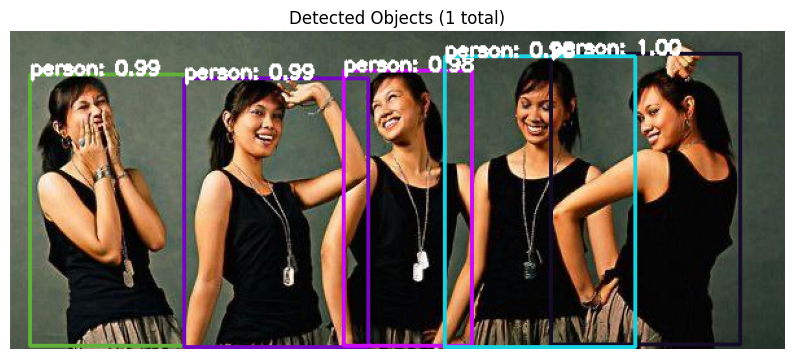

In [10]:
import torch
import torchvision
from torchvision.transforms import functional as F
import cv2
import numpy as np
import random
import matplotlib.pyplot as plt

# Load pre-trained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
model.eval()

# COCO dataset category names
COCO_INSTANCE_CATEGORY_NAMES = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light',
                                'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra',
                                'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat',
                                'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
                                'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'dining table',
                                'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase',
                                'scissors', 'teddy bear', 'hair drier', 'toothbrush']

# Function to detect objects and filter by class
def detect_objects(image_path, confidence_threshold=0.5, filter_classes=None):
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Could not load image from '{image_path}'. Please check the file path and ensure the image exists.")
        return None

    original_image = image.copy()
    image_tensor = F.to_tensor(image)

    # Perform object detection
    with torch.no_grad():
        predictions = model([image_tensor])

    boxes = predictions[0]['boxes'].cpu().numpy()
    labels = predictions[0]['labels'].cpu().numpy()
    scores = predictions[0]['scores'].cpu().numpy()

    detected_objects = {}

    # Filter and process detections
    for i, box in enumerate(boxes):
        if scores[i] >= confidence_threshold:
            label = COCO_INSTANCE_CATEGORY_NAMES[labels[i]]
            score = scores[i]

            # Filter objects by class if specified
            if filter_classes and label not in filter_classes:
                continue

            # Assign a random color for each class
            color = [random.randint(0, 255) for _ in range(3)]

            # Manually clip the bounding boxes to ensure they are within the image dimensions
            box = np.clip(box, 0, [image.shape[1], image.shape[0], image.shape[1], image.shape[0]])

            # Draw bounding box and label with specific color
            start_point = (int(box[0]), int(box[1]))
            end_point = (int(box[2]), int(box[3]))
            cv2.rectangle(original_image, start_point, end_point, color, 2)
            cv2.putText(original_image, f"{label}: {score:.2f}", start_point, cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)

            # Count detected objects
            if label in detected_objects:
                detected_objects[label]['count'] += 1
                detected_objects[label]['scores'].append(score)
            else:
                detected_objects[label] = {'count': 1, 'scores': [score]}

    # Display object count summary
    print("Detected objects summary:")
    for label, data in detected_objects.items():
        avg_score = np.mean(data['scores'])
        print(f"{label}: {data['count']} object(s), Average Confidence: {avg_score:.2f}")

    return original_image, detected_objects

# Function to display the image with detected objects
def display_detected_image(image_path, confidence_threshold=0.5, filter_classes=None):
    detected_image, detected_objects = detect_objects(image_path, confidence_threshold, filter_classes)

    if detected_image is not None:
        # Display the image with detected bounding boxes
        detected_image_rgb = cv2.cvtColor(detected_image, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10, 10))
        plt.imshow(detected_image_rgb)
        plt.axis('off')
        plt.title(f"Detected Objects ({len(detected_objects)} total)")
        plt.show()

if __name__ == "__main__":
    IMAGE_PATH = "/content/PHOTO-2024-11-27-14-38-10.jpg"

    # Define filter classes (e.g., 'person', 'dog', 'car')
    filter_classes = ['person', 'dog', 'car']

    # Display detected objects with a confidence threshold and class filter
    display_detected_image(IMAGE_PATH, confidence_threshold=0.5, filter_classes=filter_classes)
